### Streaming 
Methods: .stream() and astream()

- These methods are sync and async methods for streaming back results.

Additional parameters in streaming modes for graph state

- **values** : This streams the full state of the graph after each node is called.
- **updates** : This streams updates to the state of the graph after each node is called.

In [1]:
from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage,AIMessage, HumanMessage, AnyMessage
from langchain_core.tools import tool

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages ## used for adding messages to the list in state (reducer)

# use this to import tool_condition and ToolNode
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import InMemorySaver

from typing import Annotated, TypedDict
from dotenv import load_dotenv
import requests
import os

load_dotenv()

/Users/srinivas/Documents/Others/My_projects/Python/DSAIML/agenticai/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
# Initialize Groq model using init_chat_model (newer way of setting up models in langchain)
model = init_chat_model(
    model="llama-3.1-8b-instant",  # or any other Groq model
    model_provider="groq",
    temperature=0.7,
)

In [3]:
class ChatState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [4]:
# let us implement the chat node
def chat_node(state: ChatState) -> ChatState:
    response = model.invoke(state["messages"])
    state["messages"] = state["messages"] + [response]
    return state

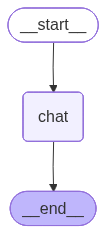

In [5]:
# now lets build a graph with memory
memory = InMemorySaver()

# initialize the graph
graph = StateGraph(ChatState)

# add nodes
graph.add_node("chat", chat_node)

# add edges
graph.add_edge(START, "chat")
graph.add_edge("chat", END)

# compile the graph
workflow = graph.compile(checkpointer=memory)
workflow

In [6]:
initial_state = {"messages": [HumanMessage(content="Hello, I'm Srini, I love football!")]}

# create config with session id
config = {"configurable": {"thread_id": "chat_1"}}

In [7]:
# run the graph
result = workflow.stream(initial_state, config=config, stream_mode="updates")

for message in result:
    print(message) 



{'chat': {'messages': [HumanMessage(content="Hello, I'm Srini, I love football!", additional_kwargs={}, response_metadata={}, id='3a4c5740-330a-4123-b99f-be25282db2da'), AIMessage(content="Nice to meet you, Srini. Football is an exciting sport, loved by millions worldwide. What's your favorite team or league? Are you more into European football, like the English Premier League or La Liga, or do you follow a specific team from other parts of the world?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 46, 'total_tokens': 104, 'completion_time': 0.090941087, 'completion_tokens_details': None, 'prompt_time': 0.016334089, 'prompt_tokens_details': None, 'queue_time': 0.006877077, 'total_time': 0.107275176}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_9ca2574dca', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--f4e536b7-76aa-4690-9287-32eb27a2be0e-0', usage_me

In [8]:
# run the graph
result = workflow.stream({"messages": [HumanMessage(content="I love cricket as well")]}, config=config, stream_mode="values")

for message in result:
    print(message) 

{'messages': [HumanMessage(content="Hello, I'm Srini, I love football!", additional_kwargs={}, response_metadata={}, id='3a4c5740-330a-4123-b99f-be25282db2da'), AIMessage(content="Nice to meet you, Srini. Football is an exciting sport, loved by millions worldwide. What's your favorite team or league? Are you more into European football, like the English Premier League or La Liga, or do you follow a specific team from other parts of the world?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 46, 'total_tokens': 104, 'completion_time': 0.090941087, 'completion_tokens_details': None, 'prompt_time': 0.016334089, 'prompt_tokens_details': None, 'queue_time': 0.006877077, 'total_time': 0.107275176}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_9ca2574dca', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--f4e536b7-76aa-4690-9287-32eb27a2be0e-0', usage_metadata={'

In [9]:
# run the graph
result = workflow.stream({"messages": [HumanMessage(content="I am into Sports!")]}, config=config, stream_mode="updates")

for message in result:
    print(message) 

{'chat': {'messages': [HumanMessage(content="Hello, I'm Srini, I love football!", additional_kwargs={}, response_metadata={}, id='3a4c5740-330a-4123-b99f-be25282db2da'), AIMessage(content="Nice to meet you, Srini. Football is an exciting sport, loved by millions worldwide. What's your favorite team or league? Are you more into European football, like the English Premier League or La Liga, or do you follow a specific team from other parts of the world?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 46, 'total_tokens': 104, 'completion_time': 0.090941087, 'completion_tokens_details': None, 'prompt_time': 0.016334089, 'prompt_tokens_details': None, 'queue_time': 0.006877077, 'total_time': 0.107275176}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_9ca2574dca', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--f4e536b7-76aa-4690-9287-32eb27a2be0e-0', usage_me

In [11]:
# run the graph
result = workflow.stream({"messages": [HumanMessage(content="I am also interested in Tennis")]}, config=config, stream_mode="values")

for message in result:
    print(message) 

{'messages': [HumanMessage(content="Hello, I'm Srini, I love football!", additional_kwargs={}, response_metadata={}, id='3a4c5740-330a-4123-b99f-be25282db2da'), AIMessage(content="Nice to meet you, Srini. Football is an exciting sport, loved by millions worldwide. What's your favorite team or league? Are you more into European football, like the English Premier League or La Liga, or do you follow a specific team from other parts of the world?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 46, 'total_tokens': 104, 'completion_time': 0.090941087, 'completion_tokens_details': None, 'prompt_time': 0.016334089, 'prompt_tokens_details': None, 'queue_time': 0.006877077, 'total_time': 0.107275176}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_9ca2574dca', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--f4e536b7-76aa-4690-9287-32eb27a2be0e-0', usage_metadata={'

#### Streaming The Responses With astream Method

**Streaming tokens**
We often want to stream more than graph state.

In particular, with chat model calls it is common to stream the **tokens** as they are generated.

We can do this using the .astream_events method, which streams back events as they happen inside nodes!

Each event is a dict with a few keys:

- event: This is the type of event that is being emitted.
- name: This is the name of event.
- data: This is the data associated with the event.
- metadata: Containslanggraph_node, the node emitting the event.

In [13]:
config = {"configurable": {"thread_id": "3"}}

result = workflow.astream_events({"messages":["Hi My name is Srini and I like to play cricket"]},config,version="v2")

async for event in result:
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi My name is Srini and I like to play cricket']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '889f1ce5-2a8a-448a-82a8-f8c4d9d4dc45', 'metadata': {'thread_id': '3'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi My name is Srini and I like to play cricket', additional_kwargs={}, response_metadata={}, id='94f37a72-8dd2-40a1-8647-7efd36fcc44a')]}}, 'name': 'chat', 'tags': ['graph:step:1'], 'run_id': '235926c8-6afe-40a9-8ac1-45b84867aef5', 'metadata': {'thread_id': '3', 'langgraph_step': 1, 'langgraph_node': 'chat', 'langgraph_triggers': ('branch:to:chat',), 'langgraph_path': ('__pregel_pull', 'chat'), 'langgraph_checkpoint_ns': 'chat:33b82f04-379e-ac18-2525-c30070ecc010'}, 'parent_ids': ['889f1ce5-2a8a-448a-82a8-f8c4d9d4dc45']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi My name is Srini and I like to play cricket', addition